# Gesture Recognition
In this group project, we are going to build a model that will be able to predict the 5 gestures correctly. This will be used to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
Thumbs up:  Increase the volume
Thumbs down: Decrease the volume
Left swipe: 'Jump' backwards 10 seconds
Right swipe: 'Jump' forward 10 seconds  
Stop: Pause the movie
 
Each video is a sequence of 30 frames (or images). The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use.

## Dataset
The data is in a zip file. The zip file contains a 'train' and a 'val' folder with two CSV files for the two folders. These folders are in turn divided into subfolders where each subfolder represents a video of a particular gesture. Each subfolder, i.e. a video, contains 30 frames (or images). Note that all images in a particular video subfolder have the same dimensions but different videos may have different dimensions. Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos). Hence, you will need to do some pre-processing to standardise the videos. 
 
Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.

In [71]:
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt

from imageio.v2 import imread
# from scipy.misc import imresize

import warnings
warnings.simplefilter('ignore')

We set the random seed so that the results don't vary drastically.

In [72]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

## Generator
In the generator, we are going to preprocess like re-sizing and cropping the images as we have images of 2 different dimensions as well as create a batch of video frames.

In [73]:
# Define a function to crop an image to a square shape
def crop_to_square(image):
    height, width, _ = image.shape
    
    # Calculate the size of the square crop
    crop_size = min(width, height)
    
    # Calculate the coordinates for the center of the image
    center_x = width // 2
    center_y = height // 2
    
    # Calculate the top-left corner of the square crop
    left = center_x - crop_size // 2
    top = center_y - crop_size // 2
    
    # Calculate the bottom-right corner of the square crop
    right = left + crop_size
    bottom = top + crop_size
    
    # Crop the image to the calculated square
    cropped_image = image[top:bottom, left:right]
    
    return cropped_image

# Define the generator function
def generator(source_path, folder_list, batch_size): #, img_height, img_width, img_idx):
    
    while True:
        # Shuffle the folder list
        t = np.random.permutation(folder_list)
        
        # Calculate the number of full batches
        num_batches = len(t) // batch_size          
#         print( 'num_batches = ', num_batches)

        for batch in range(num_batches):
            
#             plt.figure(figsize=(20,5))
            
            batch_data = np.zeros((batch_size, num_of_frames, img_height, img_width, 3))
            batch_labels = np.zeros((batch_size, num_of_classes))   #batch_labels is the one hot representation of the output

            for folder in range(batch_size):
                
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0])
                
                for idx, item in enumerate(img_idx):
                    # Construct image path
                    image_path = source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item]
                    
                    # Read and decode the image
                    image = tf.image.decode_jpeg(tf.io.read_file(image_path))
                    
                    # Plot the image before cropping and resizing
#                     plt.figure()
#                     plt.subplot(2, num_of_frames, idx+1)
#                     plt.imshow(image)
#                     plt.title('original')
                    
                    # Crop the image to a square shape
                    image = crop_to_square(image)
                    
                    # Resize the cropped image to (img_height, img_width)
                    image = tf.image.resize(image, size=(img_height, img_width))
                    
                    # Normalize the resized image
                    normalized_image = image / 255.0
                    
                    # Plot the image after cropping and resizing
#                     plt.subplot(2, num_of_frames, idx+num_of_frames+1)
#                     plt.imshow(normalized_image)
#                     plt.title('modified')
                    
                    # Store the normalized image in batch_data
                    batch_data[folder, idx] = normalized_image
                
                # Assign labels for each batch
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1
            
            plt.show()  # Display the plots
            # Yield the batch_data and batch_labels
            yield batch_data, batch_labels
        
        # Calculate the start index for the remaining data points
        start_index = num_batches * batch_size
        
        # Calculate the number of remaining data points
        remaining_size = len(t) - start_index
#         print( 'remaining_size = ', remaining_size)
        
#         plt.figure(figsize=(20,5))

        # Check if there are remaining data points
        if remaining_size > 0:
            # Initialize arrays for the partial batch
            partial_batch_data = np.zeros((remaining_size, len(img_idx), img_height, img_width, 3))
            partial_batch_labels = np.zeros((remaining_size, num_of_classes))
            
            # Process the remaining data points
            for folder in range(remaining_size):
                # Calculate the folder index
                folder_index = start_index + folder
                
                # Construct the folder path
                folder_path = source_path + '/' + t[folder_index].strip().split(';')[0]
                
                # Process images in the folder
                imgs = os.listdir(folder_path)
                for idx, item in enumerate(img_idx):
                    # Read the image
                    image_path = folder_path + '/' + imgs[item]
                    # Read and decode the image
                    image = tf.image.decode_jpeg(tf.io.read_file(image_path))
                    
                    # Plot the image before cropping and resizing
#                     plt.figure()
#                     plt.subplot(2, num_of_frames, idx+1)
#                     plt.imshow(image)
#                     plt.title('original')
                    
                    # Crop the image to a square shape
                    image = crop_to_square(image)
                    
                    # Resize the cropped image to (img_height, img_width)
                    image = tf.image.resize(image, size=(img_height, img_width))
                    
                    # Normalize the resized image
                    normalized_image = image / 255.0
                    
                    # Plot the image after cropping and resizing
#                     plt.subplot(2, num_of_frames, idx+num_of_frames+1)
#                     plt.imshow(normalized_image)
#                     plt.title('modified')

                    # Store the normalized image in partial_batch_data
                    partial_batch_data[folder, idx] = normalized_image
               
                # Assign labels for each batch
                partial_batch_labels[folder, int(t[folder_index].strip().split(';')[2])] = 1
                
            plt.show()  # Display the plots
            # Yield the remaining partial batch data and labels
            yield partial_batch_data, partial_batch_labels
        

In [74]:
# test_gen = generator(train_path, train_doc, batch_size)

In [75]:
# d = next(test_gen)[0]

Module for choosing data size.

In [76]:
# ablation
def get_data(ablation=None):
    train_doc = np.random.permutation(open('train.csv').readlines())
    val_doc = np.random.permutation(open('val.csv').readlines())
    
    train_data = []
    val_data = []
    # when ablation is None pass full training and val data
    if ablation is not None:
        # iterating train doc
        num_paths_to_use = int(len(train_doc) * ablation / 100)
        train_data = train_doc[:num_paths_to_use]
        
        # iterating val doc
        num_paths_to_use = int(len(val_doc) * ablation / 100)
        val_data = val_doc[:num_paths_to_use]
    else:
        train_data, val_data = train_doc, val_doc
    return train_data, val_data

Module for plotting graphs for loss and accuracies.

In [77]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

#     print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
#     print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))
    
    final_training_accuracy = history.history['categorical_accuracy'][-1]  # Last value in the accuracy list
    final_validation_accuracy = history.history['val_categorical_accuracy'][-1]  # Last value in the val_accuracy list

    print(f"Training Accuracy: {final_training_accuracy:.4f}")
    print(f"Validation Accuracy: {final_validation_accuracy:.4f}")

## Model

For analysing videos using neural networks, two types of architectures are used commonly. One is the standard CNN + RNN architecture in which you pass the images of a video through a CNN which extracts a feature vector for each image, and then pass the sequence of these feature vectors through an RNN.

The other popular architecture used to process videos is a natural extension of CNNs - a 3D convolutional network. We will try both architectures and choose the best for final model.

Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [78]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, Dropout, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import LSTM

##### Parameter Initialization

In [79]:
# Initialize parameters
curr_dt_time = datetime.datetime.now()

train_path = 'train'
val_path = 'val'

num_of_classes = 5 #number of output classes. There are 5 gestures to be recognised.

#total images available per video in dataset
total_images = 30

# number of epochs
num_epochs = 20 
print ('# epochs =', num_epochs)

# epochs = 20


In [80]:
# Using abalation 
# train_doc, val_doc = get_data(ablation=20) #Experiment #1 & 2

#Using full data 
train_doc, val_doc = get_data(ablation=None) #Experiment #3 & above

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


In [81]:
# number of videos in a batch fed to model
# batch_size = 100  
# batch_size = 20 
# batch_size = 40 
batch_size = 32
print('batch_size =', batch_size)

# image dimensions
# img_height, img_width = 120, 120
# img_height, img_width = 100, 100 
img_height, img_width = 80, 80
print('image = ' + str(img_height) + ' x ' + str(img_width))

#number of images/frames used per video
# num_of_frames = 30
# num_of_frames = 20 
num_of_frames = 15
print('num_of_frames =', num_of_frames)

#creating a list of image numbers to be used for a video
img_idx = np.round(np.linspace(0, total_images-1, num_of_frames)).astype(int) #[0,1,2,3,4,5,6,7,8,9,10]
print(img_idx)

#input shape for the model's 1st layer
input_shape = (num_of_frames, img_height, img_width, 3)

batch_size = 32
image = 80 x 80
num_of_frames = 15
[ 0  2  4  6  8 10 12 15 17 19 21 23 25 27 29]


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [82]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [83]:
#code to save model in models folder
model_name = 'models/' + 'model_init' + '_' + str(curr_dt_time).replace(' ','-').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', 
                             mode='auto', 
                             verbose=1, 
                             save_best_only=False, 
                             save_weights_only=False,
                             save_freq = 'epoch')

#adjust LR if loss is not changing
LR = ReduceLROnPlateau(monitor='val_loss', 
                       factor=0.1, 
                       patience=5, 
                       min_lr=0.001, 
                       verbose=1) # write the REducelronplateau code here
# LR = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.1,  # Factor to reduce learning rate by
#     patience=3,  # Number of epochs without improvement before reducing learning rate
#     min_lr=1e-6,
#     verbose=1
# )

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [84]:
#adjust the steps as per the batchsize
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### Experiment #1


- First we will try `Conv3D` model architecture because they are less complex and have comparatively less number of parameters than CNN-RNN.
- We will train with small amount of data using ablation to see if the model learns
- Since the data contains different size of images, some are `120 x 180` and some are`360 x 360`, we will resize all the images to size `120 x 120` using custiomized data generator function and see how the model performs.
- To start with we will use batch_size of `100` and `20` `epochs`.
- To start with we will use all the `30` frames available per video.

In [85]:
# # Create a Sequential model
# model = Sequential()

# model.add(Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same', activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Flatten())

# model.add(Dense(units=32, activation='relu'))

# model.add(Dense(units=num_of_classes, activation='softmax'))

# #compile model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

##### Observations

- `Out of memory error`.

##### Decision

- The device is not able to handle the large data size in a batch which depends on the `no_of_images` per video, `size` of images and `batch_size`.
- We will reduce `batch_size` to `32`, `no_of_images` to `15` and image size to `80 x 80` and see if the memory issue resolves.
- The strategy is to keep the above parameters minimum and if the memory issue is resolved then if required these parameters can be increased step by step to increase the performance.

### Experiment #2

- Using `batch_size` = `32`, `no_of_images` = `15`, and image size to `80 x 80` while rest remains the same.

In [86]:
# Create a Sequential model
# model = Sequential()

# model.add(Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same', activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Flatten())

# model.add(Dense(units=32, activation='relu'))

# model.add(Dense(units=num_of_classes, activation='softmax'))

# #compile model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

##### Observations

- No memory issues.
- `Training Accuracy: 1.0000` and `Validation Accuracy: 0.4500`
- The model is learning but overfitting.

##### Decision

- The model is learning but overfitting and training accuracy 1 indicates model memorizing train data due to small train data
- Use full training data.


### Experiment #3

- Using full training data.

In [87]:
# # Create a Sequential model
# model = Sequential()

# model.add(Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same', activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Flatten())

# model.add(Dense(units=32, activation='relu'))

# model.add(Dense(units=num_of_classes, activation='softmax'))

# #compile model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

##### Observations
- Training Accuracy: 1.0000
Validation Accuracy: 0.7100

##### Decision
- Though the validation accuracy has increased there is still overfitting.
- To regulate the model, add Dropout layer.

### Experiment #4

- Adding Dropout layer before output layer.

In [88]:
# # Create a Sequential model
# model = Sequential()

# model.add(Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same', activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Flatten())

# model.add(Dense(units=32, activation='relu'))

# model.add(Dropout(0.5))

# model.add(Dense(units=num_of_classes, activation='softmax'))

# #compile model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

##### Observations

- `Training Accuracy: 0.7074` and `Validation Accuracy: 0.6300`.

##### Decision
- There is considerable reduction in overfitting but the accuracies have dropped. 
- For model to learn more features add conv2d layer.


### Experiment #5

- Adding third conv2d layer with 64 filters and increasing the units in dense layer too.

In [89]:
# # Create a Sequential model
# model = Sequential()

# model.add(Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same', activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same', activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Flatten())

# model.add(Dense(units=64, activation='relu'))

# model.add(Dropout(0.5))

# model.add(Dense(units=num_of_classes, activation='softmax'))

# #compile model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

##### Observations

- Training Accuracy: 0.8959 and Validation Accuracy: 0.7300

##### Decision

- The accuracies have increased but there is overfitting. We will try lesser filter size.


### Experiment #6
- Change filter size/kernel_size to (2,2,2).

In [90]:
# # Create a Sequential model
# model = Sequential()

# model.add(Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(filters=32, kernel_size=(2, 2, 2), padding='same', activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(filters=64, kernel_size=(2, 2, 2), padding='same', activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Flatten())

# model.add(Dense(units=64, activation='relu'))

# model.add(Dropout(0.5))

# model.add(Dense(units=num_of_classes, activation='softmax'))

# #compile model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

##### Observations
- Training Accuracy: 0.4992
Validation Accuracy: 0.6100.

##### Decision
- Poor performance so will revert to previous filter size and try Dropout layer to reduce overfitting.


### Experiment #7

- Adding Dropout layer after flatten layer.

In [91]:
# # Create a Sequential model
# model = Sequential()

# model.add(Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same', activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same', activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Flatten())

# model.add(Dropout(0.5))

# model.add(Dense(units=64, activation='relu'))

# model.add(Dropout(0.5))

# model.add(Dense(units=num_of_classes, activation='softmax'))

# #compile model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

##### Observations
- Training Accuracy: 0.7843
Validation Accuracy: 0.7200

##### Decision
- Overfitting is reduced but accuracies decreased.
- We will try cropping images and see if it increases accuracy.


### Experiment #8

- Cropping images to a consistent square size.

In [92]:
# Create a Sequential model
model = Sequential()

model.add(Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())

model.add(Dropout(0.5))

model.add(Dense(units=64, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(units=num_of_classes, activation='softmax'))

#compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_6 (Conv3D)               │ (None, 15, 80, 80, 16) │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 7, 40, 40, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 7, 40, 40, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 3, 20, 20, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_8 (Conv3D)               │ (None, 3, 20, 20, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 1, 10, 10, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 480,517 (1.83 MB)

 Trainable params: 480,517 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

None


##### Observations
- Training Accuracy: 0.8552
Validation Accuracy: 0.8200.

##### Decision
- Best performance till now.
- Will now try increasing the image size to see if it improves performance.


### Experiment #9
- Change image size to `100 x 100`.

In [93]:
# # Create a Sequential model
# model = Sequential()

# model.add(Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same', activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same', activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Flatten())

# model.add(Dropout(0.5))

# model.add(Dense(units=64, activation='relu'))

# model.add(Dropout(0.5))

# model.add(Dense(units=num_of_classes, activation='softmax'))

# #compile model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

##### Observations
- Training Accuracy: 0.7195
Validation Accuracy: 0.6900.

##### Decision
- The performance did not imrpove so will revert back to previous model.
- Next will try increasing `no_of_images per video` to feed more information for learning and see if accuracy increases.


### Experiment #10

- change `no_of_images` per video from `15 to 20`.

In [94]:
# # Create a Sequential model
# model = Sequential()

# model.add(Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same', activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same', activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Flatten())

# model.add(Dropout(0.5))

# model.add(Dense(units=64, activation='relu'))

# model.add(Dropout(0.5))

# model.add(Dense(units=num_of_classes, activation='softmax'))

# #compile model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

##### Observations
- Training Accuracy: 0.8673
Validation Accuracy: 0.7700.

##### Decision
- Not better than previous model so will revert back.
- Will now try reducing batch-size and see if it improves performance.


### Experiment #11

- Changing batch size from `32 to 20`.

In [95]:
# # Create a Sequential model
# model = Sequential()

# model.add(Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same', activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same', activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Flatten())

# model.add(Dropout(0.5))

# model.add(Dense(units=64, activation='relu'))

# model.add(Dropout(0.5))

# model.add(Dense(units=num_of_classes, activation='softmax'))

# #compile model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

##### Observations
- Training Accuracy: 0.7843
Validation Accuracy: 0.7700.

##### Decision
- Lower accuracies than previous model so will revert back.
- Will now try CNN-RNN architecture to see if it improves performance.


### Experiment #12

- Using Conv2D-ConvLSTM2D Model.

In [96]:
# # import tensorflow as tf
# # from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, ConvLSTM2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed

# # Create a Sequential model
# model = Sequential()

# # Add TimeDistributed Conv2D layers
# model.add(TimeDistributed(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'), input_shape=input_shape))
# model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3, 3), activation='relu')))
# model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# # Add another ConvLSTM2D layer
# model.add(ConvLSTM2D(
#     filters=32,  # Number of filters in the ConvLSTM2D layer
#     kernel_size=(3, 3),  # Size of the kernel
#     activation='relu',  # Activation function
#     return_sequences=False  # Whether to return sequences (False for final output)
# ))

# model.add(Flatten())

# model.add(Dropout(0.5))

# model.add(Dense(32, activation='relu'))

# model.add(Dropout(0.5))

# # Output layer for classification
# model.add(Dense(num_of_classes, activation='softmax'))  # 5 classes, change as needed

# #compile model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

##### Observations
- Training Accuracy: 0.6501
Validation Accuracy: 0.6100.

##### Decision
- Not better than Conv2D models.


In [97]:
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=num_epochs,
                    verbose=1, 
                    callbacks=callbacks_list,
                    validation_data=val_generator, 
                    validation_steps=validation_steps,
                    class_weight=None,
                    initial_epoch=0)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2075 - loss: 1.6730
Epoch 1: saving model to models/model_init_2024-05-01-22_43_38.297768/model-00001-1.63606-0.19608-1.60026-0.24000.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - categorical_accuracy: 0.2070 - loss: 1.6713 - val_categorical_accuracy: 0.2400 - val_loss: 1.6003 - learning_rate: 0.0010
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.1709 - loss: 1.5998
Epoch 2: saving model to models/model_init_2024-05-01-22_43_38.297768/model-00002-1.59917-0.19005-1.57932-0.18000.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - categorical_accuracy: 0.1718 - loss: 1.5998 - val_categorical_accuracy: 0.1800 - val_loss: 1.5793 - learning_rate: 0.0010
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2410 - loss: 1.5562
Epoch 3: saving model to models/model_init_2024-05-01-22_43_38.297768/model-00003-1.52899-0.28054-1.44140-0.35000.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 57

21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - categorical_accuracy: 0.8064 - loss: 0.4574 - val_categorical_accuracy: 0.8300 - val_loss: 0.4980 - learning_rate: 0.0010
Epoch 20/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.8578 - loss: 0.3656
Epoch 20: saving model to models/model_init_2024-05-01-22_43_38.297768/model-00020-0.38311-0.85520-0.49797-0.82000.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - categorical_accuracy: 0.8576 - loss: 0.3664 - val_categorical_accuracy: 0.8200 - val_loss: 0.4980 - learning_rate: 0.0010


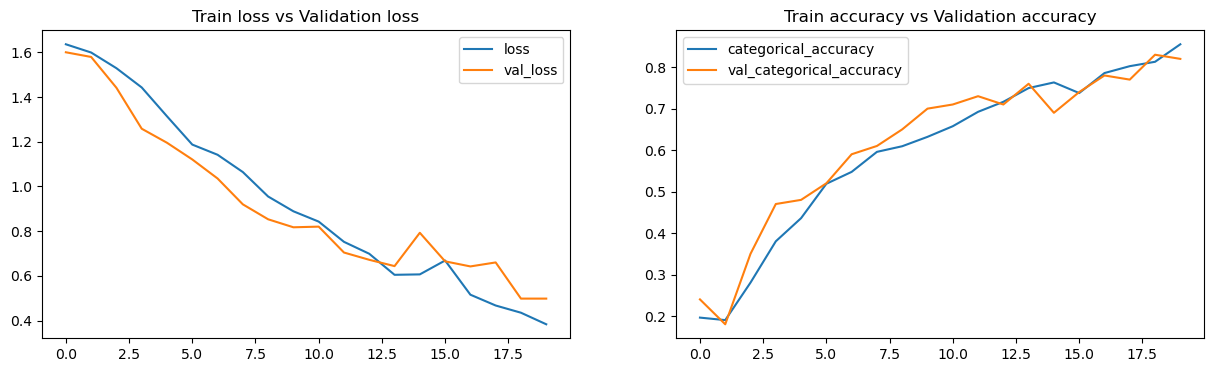

Training Accuracy: 0.8552
Validation Accuracy: 0.8200


In [98]:
plotModelHistory(history)

### Conclusion

##### We found that the Conv3D model built in experiment #8 is the best with `Training Accuracy = 0.8552 & Validation Accuracy = 0.8200 and total parameters = 480,517 (1.83 MB)`